In [1]:
import numpy as np
import sys
import re
import os
import cygnus_lib as cy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line, resize, rescale)
import scipy.ndimage
from skimage.transform import hough_circle, hough_circle_peaks
from scipy.stats import norm
import scipy.stats as stats

import pandas as pd
import pickle
import time
from IPython import display

%matplotlib inline
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
plt.rcParams['font.serif'] = ['Bitstream Vera Sans']
x_resolution = y_resolution = 2048
from itertools import combinations

In [2]:
dataSelection = 'LAB'
runI = [848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860]
runI = [828, 827, 826, 825, 824, 823]
dataSelection = 'FNG'
runI = [813, 814, 815, 826]
dataSelection = 'LAB'
runI = [741, 742]
dataSelection = 'LAB'
runI = [818]
start_image_to_read = 0
max_image_to_read = 0
for nRi in range(0,len(runI)):
#############  mean and sigma file generator ############################
    try:
        nImag=np.size(cy.swift_listdir(cy.file2FullPathCygnus(dataSelection, runI[nRi],'H5')))
        print ("# of Image Files: %d" % (nImag))
    
    except:
        print ("ERROR: No file %d" % (runI[nRi]))
        break
    if max_image_to_read != 0:
        nImag = max_image_to_read   
    print ("WARNING: data will be anlyzed from %d to %d" % (start_image_to_read, nImag))
    
    m_image = np.zeros((x_resolution, y_resolution), dtype=np.float64)
    s_image = np.zeros((x_resolution, y_resolution), dtype=np.float64)

    n0 = 0
    for iImg in range(start_image_to_read, nImag):
        image = cy.swift_read_image_h5(cy.imageFile2FullPathCygnus(
            dataSelection, runI[nRi], iImg))
        m_image += image
        s_image += image**2 
        if n0 > 0:  # print progress and debung info for poit 200, 200...
            print ("Image[200,200]: %d => %.2f %.2f %.2f " % (iImg,
                                             image[200,200],
                                             np.sqrt((s_image[200,200] - 
                                                     m_image[200,200]**2 
                                                      / (n0+1)) / n0),
                                             m_image[200,200]/(n0+1),
                                             ))
        n0 += 1
    m_image = m_image/n0
    s_image = np.sqrt((s_image - m_image**2 * n0) / (n0 - 1))
    
###### print Info and Save OutPut ######################################
    
    print ("sigma %f" % (s_image[200,200]))
    fileoutm = ("./data/run%d_mean.h5" % (runI[nRi]))
    cy.write_image_h5(fileoutm, m_image)
    fileouts = ("./data/run%d_sigma.h5" % (runI[nRi]))
    cy.write_image_h5(fileouts, s_image)
    print("DONE OUTPUT on files: %s, %s", (fileoutm, fileouts))

# of Image Files: 100
Image[200,200]: 1 => 97.00 0.71 97.50 
Image[200,200]: 2 => 98.00 0.58 97.67 
Image[200,200]: 3 => 101.00 1.73 98.50 
Image[200,200]: 4 => 98.00 1.52 98.40 
Image[200,200]: 5 => 101.00 1.72 98.83 
Image[200,200]: 6 => 100.00 1.63 99.00 
Image[200,200]: 7 => 98.00 1.55 98.88 
Image[200,200]: 8 => 101.00 1.62 99.11 
Image[200,200]: 9 => 94.00 2.22 98.60 
Image[200,200]: 10 => 101.00 2.23 98.82 
Image[200,200]: 11 => 97.00 2.19 98.67 
Image[200,200]: 12 => 102.00 2.29 98.92 
Image[200,200]: 13 => 98.00 2.21 98.86 
Image[200,200]: 14 => 100.00 2.15 98.93 
Image[200,200]: 15 => 96.00 2.21 98.75 
Image[200,200]: 16 => 97.00 2.18 98.65 
Image[200,200]: 17 => 97.00 2.15 98.56 
Image[200,200]: 18 => 98.00 2.09 98.53 
Image[200,200]: 19 => 100.00 2.06 98.60 
Image[200,200]: 20 => 97.00 2.04 98.52 
Image[200,200]: 21 => 100.00 2.02 98.59 
Image[200,200]: 22 => 96.00 2.04 98.48 
Image[200,200]: 23 => 98.00 2.00 98.46 
Image[200,200]: 24 => 98.00 1.96 98.44 
Image[200,200]: 25

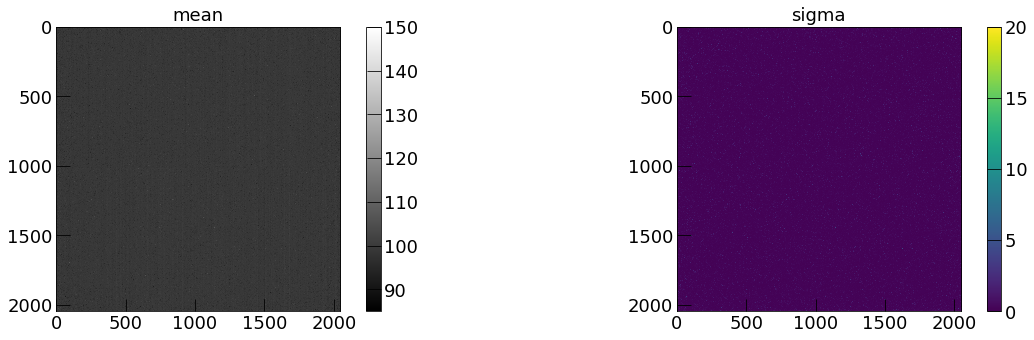

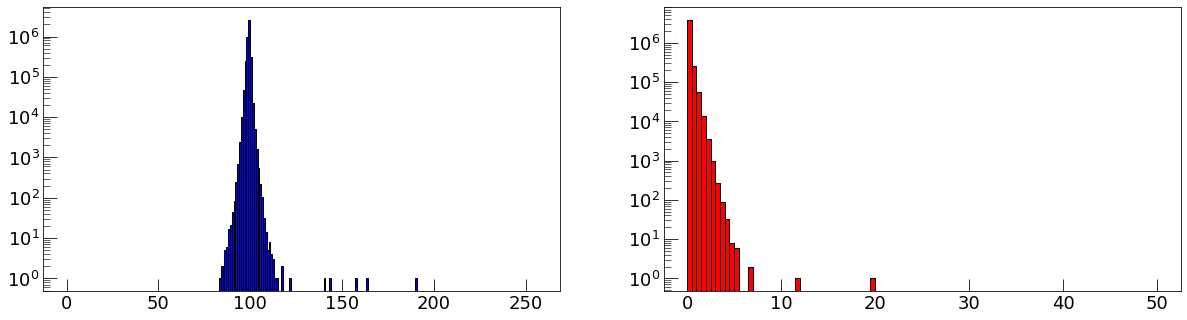

In [5]:
dataSelection = 'LAB'
runI = 818
cy.set_atlas_style('long')
run = 817
try:
    fileoutm = ("./data/run%d_mean.h5" % (run))
    imagem = cy.read_image_h5(fileoutm)
except:
    print ("No file for run %s, run script runs-pedestals.ipynb" % run)
try: 
    fileouts = ("./data/run%d_sigma.h5" % (run))
    images = cy.read_image_h5(fileouts)
except:
    print ("No file for run %s, run script runs-pedestals.ipynb" % run)


fig, ax = plt.subplots(1,2)
im = ax[0].imshow(imagem, cmap="gray", vmin=85,vmax=150)
fig.colorbar(im, ax=ax[0])
ax[0].set_title("mean")
ax[1].set_title("sigma")
im = ax[1].imshow(images, vmin=0,vmax=20)
fig.colorbar(im, ax=ax[1])
plt.show()
fig, ax = plt.subplots(1,2)
ax[0].hist(imagem.ravel(), bins=256, range=(0.0, 256.0), fc='b', ec='k')
ax[1].hist(images.ravel(), bins=100, range=(0.0, 50.0), fc='r', ec='k')
ax[0].set_yscale("log")
ax[1].set_yscale("log")

plt.show()